# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [ ]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (4056/4056), done.
remote: Compressing objects: 100% (1626/1626), done.
remote: Total 4056 (delta 2387), reused 3946 (delta 2369), pack-reused 0
Receiving objects: 100% (4056/4056), 649.87 MiB | 37.42 MiB/s, done.
Resolving deltas: 100% (2387/2387), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a51619fe4a0>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [ ]:
# to solve a bug
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [ ]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# get the summary of the model
summary(model_0, input_size=[32, 3, 224, 224], col_names=["input_size", "output_size", 'num_params', 'trainable'], row_settings=["var_names"])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 8.757 seconds


### Make predictions on the entire test dataset with the model

In [ ]:
test_loss, test_accuracy = engine.test_step(model=model_0, dataloader=test_dataloader, loss_fn=loss_fn, device=device)
print('Loss:',round(test_loss,3))
print('Accuracy:',round(test_accuracy,3))

Loss: 0.624
Accuracy: 0.897


### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.5 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19

0.23.1


In [ ]:
model_0.eval()
y_target = torch.tensor([]).to(device).type(torch.cuda.LongTensor)
y_predicted = torch.tensor([]).to(device).type(torch.cuda.LongTensor)
y_probas = torch.tensor([]).to(device).type(torch.cuda.FloatTensor)

with torch.inference_mode():
  for X,y in test_dataloader:
    X, y = X.to(device), y.to(device)
    y_logit = model_0(X)
    y_pred = torch.max(torch.softmax(y_logit, dim=1), dim=1)

    y_predicted = torch.concat([y_predicted, y_pred.indices])
    y_probas = torch.concat([y_probas, y_pred.values])
    y_target = torch.concat([y_target, y])

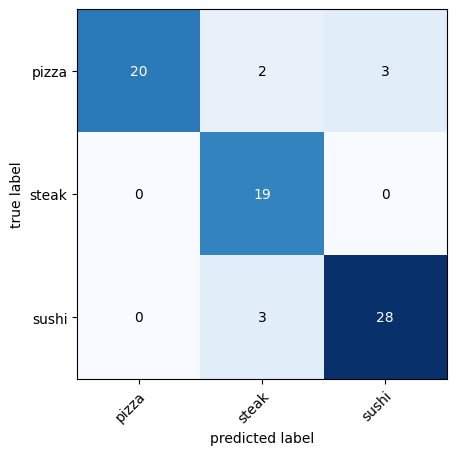

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_target=y_target.cpu(), y_predicted=y_predicted.cpu())
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=class_names)
plt.show()

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [ ]:
from typing import List, Tuple
from PIL import Image

def pred_image(
    model: torch.nn.Module,
    image_path: str,
    device: torch.device,
    transform: torchvision.transforms,
):
    # Open image
    img = Image.open(image_path)

    # Set the transformation
    image_transform = transform

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        X = image_transform(img).unsqueeze(dim=0).to(device)
        y_logit = model(X)
        y_pred = torch.max(torch.softmax(y_logit, dim=1), dim=1)

    return y_pred.indices, y_pred.values

def plot_image(
    image_path: str,
    true_label: int,
    pred_label: int,
    pred_probs: float
):
    # Open image
    img = Image.open(image_path)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"True: {true_label} | Pred: {pred_label} | Prob: {pred_probs:.3f}"
    )
    plt.axis(False)
    plt.show()

In [ ]:
model_0.eval()
y_target = np.array([], dtype=str)
y_predicted = np.array([], dtype=str)
y_path = np.array([], dtype=str)
y_probas = torch.tensor([]).to(device).type(torch.cuda.FloatTensor)

with torch.inference_mode():
  for path in test_dir.glob('**/*.jpg'):
    img_path = str(path)
    y_pred, y_proba = pred_image(
        model=model_0,
        image_path=img_path,
        device=device,
        transform=simple_transform
    )

    y_predicted = np.hstack([y_predicted, class_names[y_pred.item()]])
    y_target = np.hstack([y_target, img_path.split('/')[3]])
    y_path = np.hstack([y_path, img_path])
    y_probas = torch.concat([y_probas, y_proba])

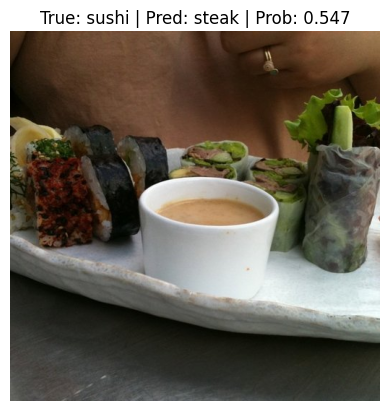

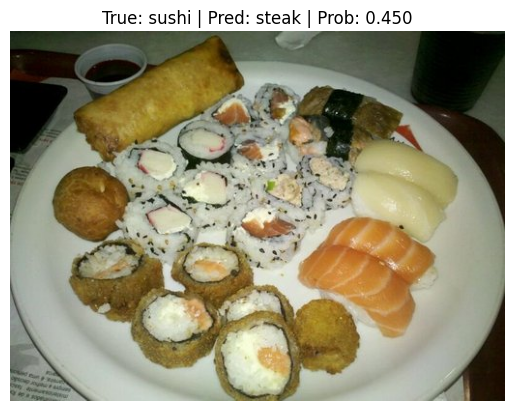

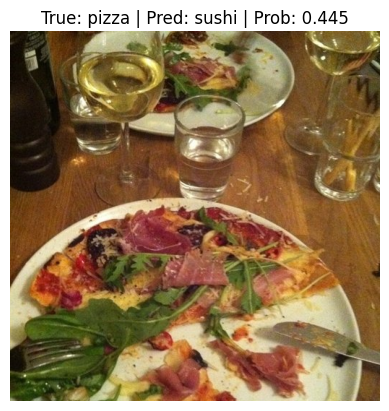

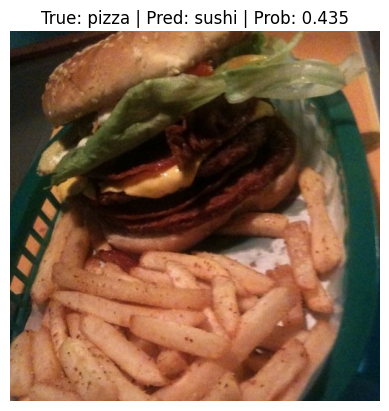

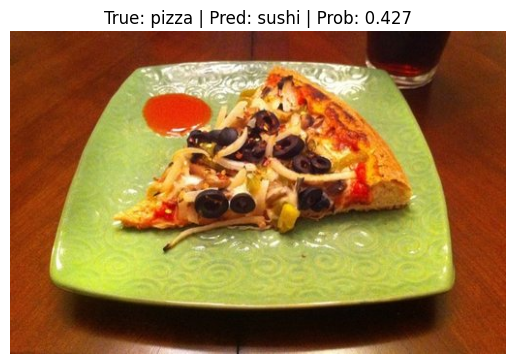

In [ ]:
import pandas as pd
df_prediction = pd.DataFrame({'y_true':y_target, 'y_predicted':y_predicted, 'y_probas':y_probas.cpu(), 'img_path':y_path})
df_wrong = df_prediction[df_prediction['y_true'] != df_prediction['y_predicted']].sort_values(by='y_probas', ascending=False).head(5)

for idx,row in df_wrong.iterrows():
  plot_image(
    image_path=row.img_path,
    true_label=row.y_true,
    pred_label=row.y_predicted,
    pred_probs=row.y_probas
)

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

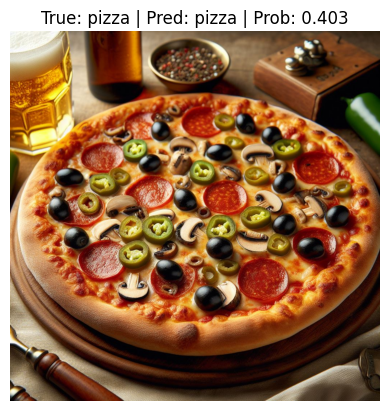

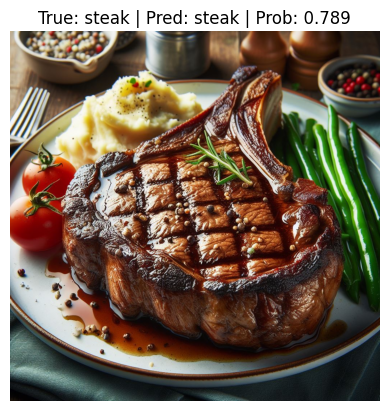

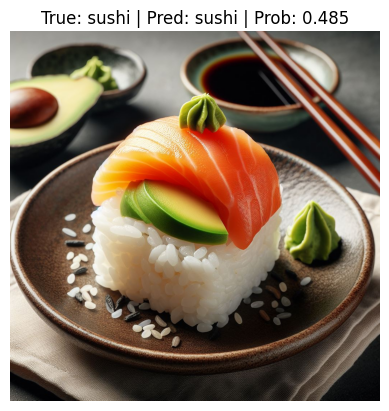

In [ ]:
model_0.eval()
y_target = np.array([], dtype=str)
y_predicted = np.array([], dtype=str)
y_path = np.array([], dtype=str)
y_probas = torch.tensor([]).to(device).type(torch.cuda.FloatTensor)

with torch.inference_mode():
  for img_path in ['pizza.jpeg', 'steak.jpeg', 'sushi.jpeg']:
    y_pred, y_proba = pred_image(
        model=model_0,
        image_path=img_path,
        device=device,
        transform=simple_transform
    )

    y_predicted = np.hstack([y_predicted, class_names[y_pred.item()]])
    y_target = np.hstack([y_target, img_path.split('.')[0]])
    y_path = np.hstack([y_path, img_path])
    y_probas = torch.concat([y_probas, y_proba])

df_prediction = pd.DataFrame({'y_true':y_target, 'y_predicted':y_predicted, 'y_probas':y_probas.cpu(), 'img_path':y_path})

for idx,row in df_prediction.iterrows():
  plot_image(
    image_path=row.img_path,
    true_label=row.y_true,
    pred_label=row.y_predicted,
    pred_probs=row.y_probas
)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup the model with pretrained weights and send it to the target device
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_1.features.parameters():
    param.requires_grad = False

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0287 | train_acc: 0.4414 | test_loss: 0.8784 | test_acc: 0.6525
Epoch: 2 | train_loss: 0.9223 | train_acc: 0.6445 | test_loss: 0.6742 | test_acc: 0.9062
Epoch: 3 | train_loss: 0.7459 | train_acc: 0.8555 | test_loss: 0.6537 | test_acc: 0.8655
Epoch: 4 | train_loss: 0.6969 | train_acc: 0.7500 | test_loss: 0.6505 | test_acc: 0.8456
Epoch: 5 | train_loss: 0.6842 | train_acc: 0.7734 | test_loss: 0.6101 | test_acc: 0.8665
Epoch: 6 | train_loss: 0.5931 | train_acc: 0.7812 | test_loss: 0.5043 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.5501 | train_acc: 0.7695 | test_loss: 0.4704 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5146 | train_acc: 0.8867 | test_loss: 0.4670 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.5462 | train_acc: 0.8086 | test_loss: 0.5091 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.4630 | train_acc: 0.9180 | test_loss: 0.4971 | test_acc: 0.8873
[INFO] Total training time: 21.387 seconds


In [ ]:
# Test the new model
test_loss, test_accuracy = engine.test_step(model=model_1, dataloader=test_dataloader, loss_fn=loss_fn, device=device)
print('Loss:',round(test_loss,3))
print('Accuracy:',round(test_accuracy,3))

Loss: 0.497
Accuracy: 0.887


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a4fbdae6aa0>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup the model with pretrained weights and send it to the target device
model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_2.features.parameters():
    param.requires_grad = False

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

### Train a model with 20% of the data

In [ ]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9489 | train_acc: 0.5917 | test_loss: 0.6732 | test_acc: 0.8824
Epoch: 2 | train_loss: 0.7083 | train_acc: 0.8000 | test_loss: 0.5323 | test_acc: 0.8824
Epoch: 3 | train_loss: 0.5881 | train_acc: 0.8417 | test_loss: 0.4617 | test_acc: 0.8886
Epoch: 4 | train_loss: 0.4978 | train_acc: 0.8479 | test_loss: 0.3997 | test_acc: 0.9313
Epoch: 5 | train_loss: 0.4679 | train_acc: 0.8229 | test_loss: 0.3759 | test_acc: 0.9068
Epoch: 6 | train_loss: 0.4144 | train_acc: 0.8854 | test_loss: 0.3540 | test_acc: 0.9318
Epoch: 7 | train_loss: 0.4633 | train_acc: 0.8438 | test_loss: 0.3426 | test_acc: 0.9313
Epoch: 8 | train_loss: 0.3304 | train_acc: 0.9042 | test_loss: 0.3449 | test_acc: 0.8858
Epoch: 9 | train_loss: 0.3474 | train_acc: 0.8854 | test_loss: 0.2855 | test_acc: 0.9437
Epoch: 10 | train_loss: 0.3025 | train_acc: 0.9125 | test_loss: 0.2818 | test_acc: 0.9284
[INFO] Total training time: 46.293 seconds


In [ ]:
# Test the new model
test_loss, test_accuracy = engine.test_step(model=model_2, dataloader=test_dataloader_20_percent, loss_fn=loss_fn, device=device)
print('Loss:',round(test_loss,3))
print('Accuracy:',round(test_accuracy,3))

Loss: 0.282
Accuracy: 0.928


## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

### Pre-trained model and data

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# prepare the data loaders
transform_resnet = ResNet50_Weights.IMAGENET1K_V1.transforms()
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir_20_percent,
    transform=transform_resnet,
    batch_size=32,
    num_workers=os.cpu_count()
)

# get the pretrained model
model_resnet = resnet50(weights='DEFAULT', progress=True).to(device)

# freeze all the parameters
for params in model_resnet.parameters():
  params.requires_grad = False

# modify the classifier layer
model_resnet.fc = nn.Linear(in_features=2048, out_features=3, device=device)

# get the summary
summary(model_resnet, input_size=[32, 3, 224, 224], col_names=["input_size", "output_size", 'num_params', 'trainable'], row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
ResNet (ResNet)                          [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]         [32, 64, 112, 112]        (9,408)                   False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]        [32, 64, 112, 112]        (128)                     False
├─ReLU (relu)                            [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential (layer1)                    [32, 64, 56, 56]          [32, 256, 56, 56]         --                        False
│    └─Bottleneck (0)                    [32, 64, 56, 56]          [32, 256, 56, 56]         --                        False


### Training the model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Setup training and save the results
model_resnet_results = engine.train(model=model_resnet,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9814 | train_acc: 0.6125 | test_loss: 0.8065 | test_acc: 0.8659
Epoch: 2 | train_loss: 0.7156 | train_acc: 0.8479 | test_loss: 0.6394 | test_acc: 0.8824
Epoch: 3 | train_loss: 0.5849 | train_acc: 0.8542 | test_loss: 0.5074 | test_acc: 0.9375
Epoch: 4 | train_loss: 0.4976 | train_acc: 0.8875 | test_loss: 0.4579 | test_acc: 0.9347
Epoch: 5 | train_loss: 0.4115 | train_acc: 0.9292 | test_loss: 0.4256 | test_acc: 0.9256
Epoch: 6 | train_loss: 0.3985 | train_acc: 0.8750 | test_loss: 0.4098 | test_acc: 0.9437
Epoch: 7 | train_loss: 0.3275 | train_acc: 0.9354 | test_loss: 0.3918 | test_acc: 0.9437
Epoch: 8 | train_loss: 0.3059 | train_acc: 0.9354 | test_loss: 0.3546 | test_acc: 0.9375
Epoch: 9 | train_loss: 0.3357 | train_acc: 0.9167 | test_loss: 0.3159 | test_acc: 0.9437
Epoch: 10 | train_loss: 0.2648 | train_acc: 0.9583 | test_loss: 0.3280 | test_acc: 0.9409
[INFO] Total training time: 48.578 seconds


In [ ]:
# Test the new model
test_loss, test_accuracy = engine.test_step(model=model_resnet, dataloader=test_dataloader_20_percent, loss_fn=loss_fn, device=device)
print('Loss:',round(test_loss,3))
print('Accuracy:',round(test_accuracy,3))

Loss: 0.328
Accuracy: 0.941


# Final comparison

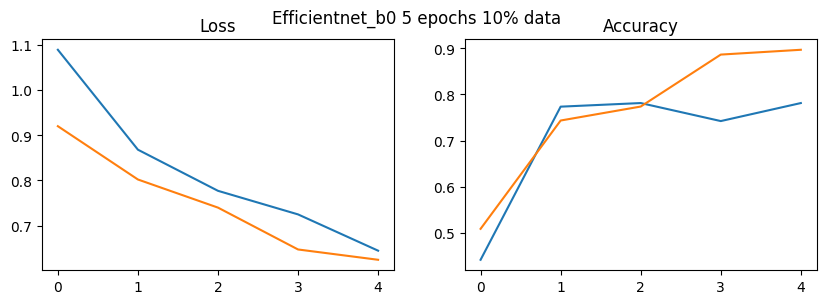

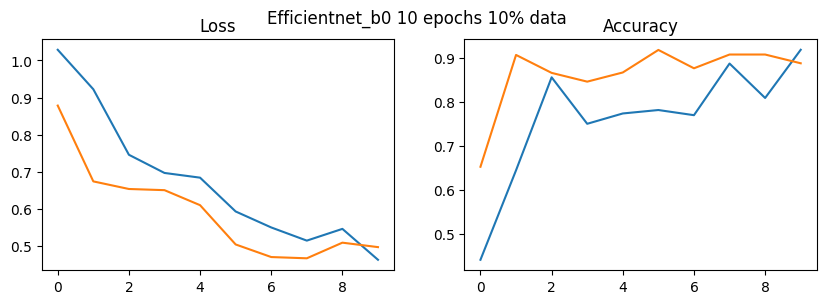

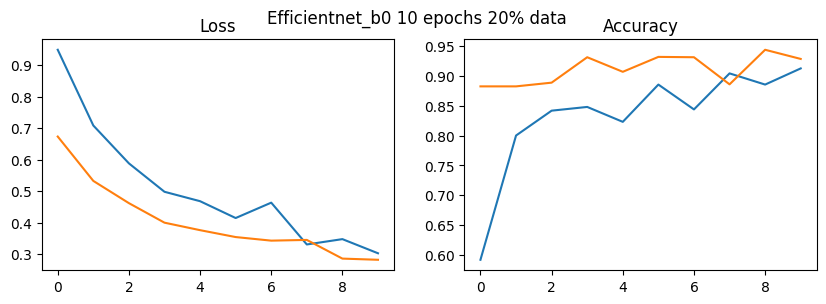

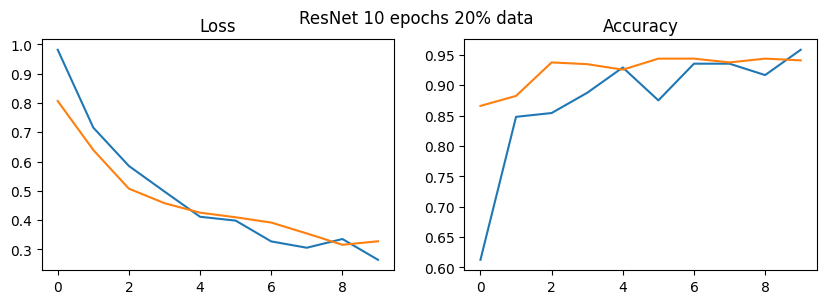

In [ ]:
for result, title in zip(
    [model_0_results, model_1_results, model_2_results, model_resnet_results],
    ['Efficientnet_b0 5 epochs 10% data', 'Efficientnet_b0 10 epochs 10% data', 'Efficientnet_b0 10 epochs 20% data', 'ResNet 10 epochs 20% data']
  ):
  # create df
  df_model = pd.DataFrame(result)
  # plot
  fig, axs = plt.subplots(1, 2, figsize=(10, 3))
  axs[0].plot(df_model.train_loss, label='train loss')
  axs[0].plot(df_model.test_loss, label='test loss')
  axs[0].set_title('Loss')
  axs[1].plot(df_model.train_acc, label='train accuracy')
  axs[1].plot(df_model.test_acc, label='test accuracy')
  axs[1].set_title('Accuracy')
  plt.suptitle(title)
  plt.show()

## The best performing model is **resnet50** with **20% of the data**:
**Test Loss**: 0.328\
**Test Accuracy**: 0.941